# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import Counter
import re




# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

         Id   ProductId          UserId  HelpfulnessNumerator  \
0    914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1    354887  6303079709  A2I8RXJN80A2D2                     0   
2   1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3   1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4    475323  630574453X  A13NM1PES9OXVN                     2   
5    353326  6303049079   AI0OAQ6E2O8VF                     7   
6     20785  0767835980  A1JH5J1KQAUBMP                     0   
7    161632  0800113055   AMMEMPM9MPS55                     3   
8   1131507  B0011KQSWM  A3T0OTH5072YRE                     0   
9     38793  0780631684  A3J845PJ4IG68M                     2   
10   753231  B00009ATIX   AW5YAI4VDA5UE                     2   
11   318954  6302530237  A39NXAD50F6YVZ                     5   
12  1315774  B0030VBGJK   AK0CENM3LUM28                     5   
13   439728  6304925131  

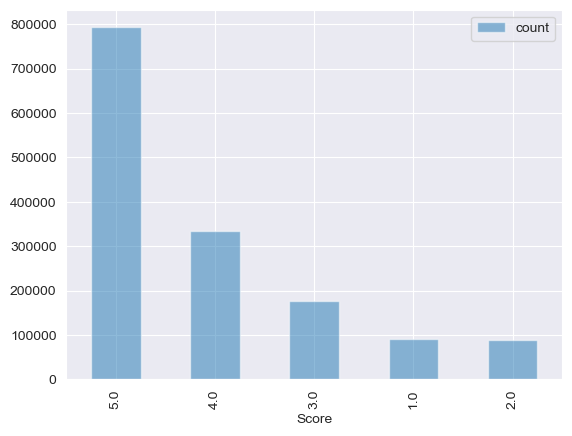


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head(20))
print()
print(testingSet.head(20))

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

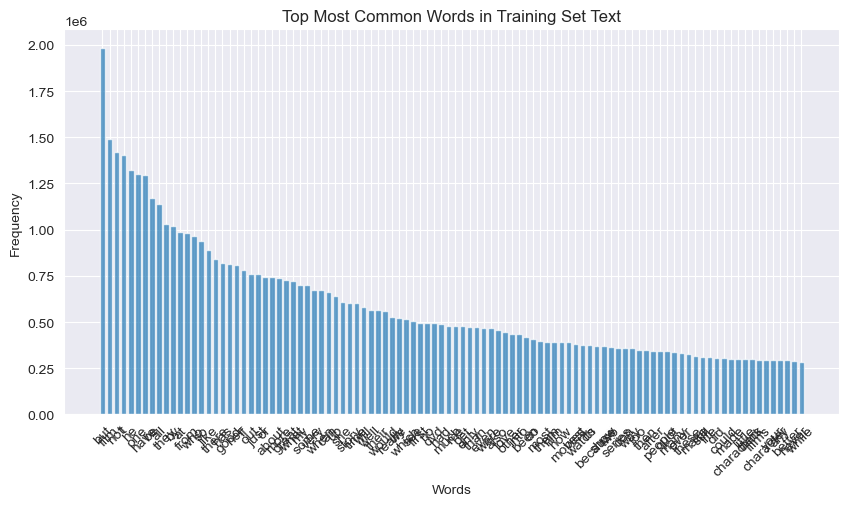

In [3]:
text_data = ' '.join(trainingSet['Text'].dropna()) 


words = re.findall(r'\w+', text_data.lower()) 


stop_words = ['a','an','the','and','this','that', 'of', 'to', 'in', 'for', 'with', 'on', 'i', 'as', 'it', 's', 'is', 'was', 'movie', 'you', 'are', 'firm', 'his']
words = [word for word in words if word not in stop_words]

word_counts = Counter(words) 

common_words = word_counts.most_common(100)
words, counts = zip(*common_words) 

plt.figure(figsize=(10, 5))
plt.bar(words, counts, alpha=0.7)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Most Common Words in Training Set Text')
plt.xticks(rotation=45)
plt.show()

In [4]:
def wordVector(inputStr):
    wordDic = {"but": 0, "not":1, "good": 2, "bad":3, "like":4, "very": 5, "well": 6, "really": 7, "no":8, "!": 9}
    curVector = [0] * 10
    for word in inputStr:
        if word in wordDic.keys():
            curVector[wordDic[word]] += 1
    return curVector
    

def cos(inputStr):
    str_list = inputStr.split(" ")
    v = wordVector(str_list)
    x = np.array(v)
    defaultVector = [472, 300, 270, 244, 218, 206, 192, 189, 182, 200]

    y = np.array(defaultVector)
    num = x.dot(y.T)
    if num == 0:
        return 0
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom



def add_features_to(df):

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['HelpfulnessDiff'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
    df['Text'] = df['Text'].fillna('')  
    df['TextLen'] = df['Text'].apply(len)
    df['TextCos'] = df['Text'].apply(cos)
    df['Summary'] = df['Summary'].fillna('')  
    df['SummaryLen'] = df['Summary'].apply(len)
    df['SummaryCos'] = df['Summary'].apply(cos)
    df['user_helpfulness_numerator_mean'] =  df.groupby('UserId')['HelpfulnessNumerator'].transform('mean')
    df['user_helpfulness_numerator_median'] =  df.groupby('UserId')['HelpfulnessNumerator'].transform('median')
    df['user_helpfulness_numerator_diff'] =  df.groupby('UserId')['HelpfulnessNumerator'].transform('max') - df.groupby('UserId')['HelpfulnessNumerator'].transform('min')
    df['product_helpfulness_numerator_mean'] =  df.groupby('ProductId')['HelpfulnessNumerator'].transform('mean')
    df['product_helpfulness_numerator_median'] =  df.groupby('ProductId')['HelpfulnessNumerator'].transform('median')
    df['product_helpfulness_numerator_diff'] =  df.groupby('ProductId')['HelpfulnessNumerator'].transform('max') - df.groupby('ProductId')['HelpfulnessNumerator'].transform('min')

    return df

train = add_features_to(trainingSet)

X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

X_train =  train[train['Score'].notnull()]

X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
features = ['TextLen', 'Helpfulness', "TextCos", "HelpfulnessNumerator", "HelpfulnessDenominator", "SummaryLen", "SummaryCos", "HelpfulnessDiff", "Time", "user_helpfulness_numerator_diff","user_helpfulness_numerator_median", "product_helpfulness_numerator_median", "product_helpfulness_numerator_diff" ]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]
 
print(X_train_select.head(20))
scaler = StandardScaler()
X_train_select = scaler.fit_transform(X_train_select)
X_test_select = scaler.transform(X_test_select)
X_submission_select = scaler.transform(X_submission_select)


         TextLen  Helpfulness   TextCos  HelpfulnessNumerator  \
131283      3707       1.0000  0.650177                    13   
1202017      720       1.0000  0.649113                     1   
511808       295       0.6000  0.613564                     6   
955172      2255       0.7500  0.000000                     3   
735507       363       0.0000  0.264191                     0   
737296      1969       1.0000  0.531412                     2   
120199       205       1.0000  0.000000                     2   
1431338      409       0.0000  0.572010                     0   
65177        432       0.2500  0.229046                     1   
822398       187       0.0000  0.000000                     0   
1115253      290       1.0000  0.000000                     2   
562626       228       0.2500  0.572010                     1   
288844       162       0.0000  0.661552                     0   
153962       686       0.8125  0.692686                    13   
1354615      602       1.

In [7]:
X_train_scaled_df = pd.DataFrame(X_train_select, columns=features)

print(X_train_scaled_df.head(20))

     TextLen  Helpfulness   TextCos  HelpfulnessNumerator  \
0   2.329668     1.432005  0.818719              0.517953   
1  -0.169064     1.432005  0.814765             -0.142074   
2  -0.524591     0.478024  0.682701              0.132937   
3   1.115018     0.835767 -1.596694             -0.032069   
4  -0.467707    -0.952949 -0.615222             -0.197076   
5   0.875769     1.432005  0.377506             -0.087072   
6  -0.599880     1.432005 -1.596694             -0.087072   
7  -0.429226    -0.952949  0.528329             -0.197076   
8  -0.409986    -0.356710 -0.745785             -0.142074   
9  -0.614937    -0.952949 -1.596694             -0.197076   
10 -0.528774     1.432005 -1.596694             -0.087072   
11 -0.580639    -0.356710  0.528329             -0.142074   
12 -0.635851    -0.952949  0.860978             -0.197076   
13 -0.197506     0.984826  0.976640              0.517953   
14 -0.267775     1.432005  1.137544             -0.142074   
15  1.341719     1.43200

# Model Creation

In [8]:
# Learn the model
# from sklearn.ensemble import RandomForestClassifier

model = KNeighborsClassifier(n_neighbors=300).fit(X_train_select, Y_train)
# model = RandomForestClassifier(n_estimators=100).fit(X_train_select, Y_train)

Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5660453066764332


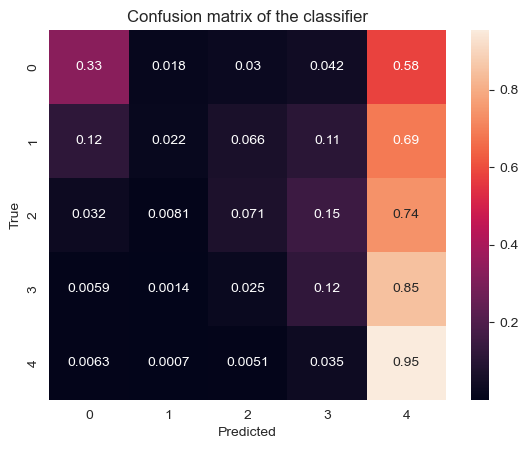

In [9]:
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [10]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)